# Train MPOX detection models

Based on theh paper *"Deep learning based detection of monkeypox virus using skin lesion images"* by T. Nayak et al., 2023

Will fine tune a CNN model:
- Dataset: [MSLD-v1](https://github.com/mHealthBuet/Monkeypox-Skin-Lesion-Dataset)
    - Binary: Monkeypox, Others (chickenpox and measles)
    - 224 x 224 x 3
	- 228 original images (102 'Monkeypox'; 126 'Others'). 
	- augmented to 3,192 images (1,428 'Monkeypox'; 1764 in 'Others').
- Pretrained model: ResNet-18 trained with Imagenet-1k
- Hyperparameters:
	- BS: [16 32 64]
	- LR:  [0.01 0.001]
    - nbr epochs: 200

## Imports and Setup

In [1]:
from eccore.ipython import nb_setup
nb_setup()

import matplotlib.pyplot as plt
import re
import torch
import umap

from pprint import pprint
from uuid import uuid4
from IPython.display import Markdown, display


from fastai import __version__ as fastai_version
from fastai.vision.all import *
from fastai.callback.all import ShowGraphCallback
from pathlib import Path
from utils import run_experiment, create_image_features, plot_features, parse_saved_fnames, ROOT, DATASETS
from utils import validate_models, plot_training_and_validation_metrics, model_weight_files

print(f"Using fastai version {fastai_version}")
saved = ROOT / "saved"
data = ROOT / "data"

train_ds = "msld-v1"
p2train_ds = DATASETS[train_ds]['path']
assert p2train_ds.is_dir(), f"Training dataset path {p2train_ds} is not a directory."
print(f"This notebook will use {train_ds} training dataset ({p2train_ds})")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# styles = plt.style.available
plt.style.use('default')

Added path: /home/vtec/projects/bio/mpox-prestudy/src
Set autoreload mode
Using fastai version 2.8.3
This notebook will use msld-v1 training dataset (/home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented)
Using device: cuda


In [2]:
imgs_train_ds = get_image_files(p2train_ds)
imgs_mpox = get_image_files(p2train_ds / "Monkeypox")
imgs_others = get_image_files(p2train_ds / "Others")
print(f"Training dataset ({train_ds}): {len(imgs_train_ds):,} images found in {p2train_ds}")
print(f" - Monkeypox: {len(imgs_mpox):,} images")
print(f" - Others:    {len(imgs_others):,} images")

Training dataset (msld-v1): 3,192 images found in /home/vtec/projects/bio/mpox-prestudy/data/MSLD-v1/Augmented
 - Monkeypox: 1,428 images
 - Others:    1,764 images


Quick review of the training dataset

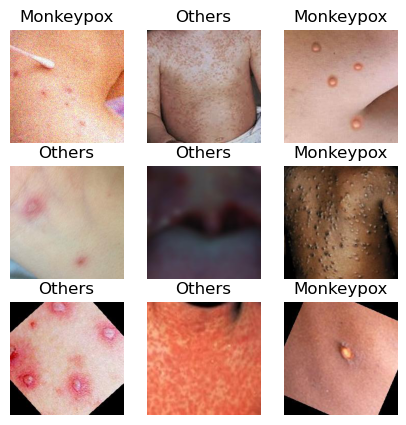

In [3]:
dls = ImageDataLoaders.from_folder(
    path=p2train_ds,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=32
)
dls.show_batch(max_n=9, figsize=(5,5), show=True)

In [13]:
# run_experiment(resnet18, train_ds='msld-v1', freeze_epochs=1, n_epoch=4, lr=1e-3, bs=32, suggested_lr='minimum', save_records=False)

## Fine tune model (resnet18)

| # | lr | bs | Train Loss | Val Acc | Val Loss | Val Recall  | Val Specificity | Val Precision | Val Acc | Val F1 |
| - | -  | -  | -          | -       | -        | -           | -               | -             | -       | -      |
| 1 |1e-3| 32 |  1.33E-06  | 99.4987 | 0.0375   | 0.988795518 | 1               | 1             | 0.994987469 | 0.994366197 |
| 2 |1e-3| 16 |  1.71E-07  | 99.4987 | 0.0235   | 0.994397759 | 0.995464853     | 0.994397759   | 0.994987469 | 0.994397759 |
| 3 |1e-3| 64 |  1.51E-05  | 97.7444 | 0.0784   | 0.969187675 | 0.984126984     | 0.980169972   | 0.977443609 | 0.974647887 |
| 4 |1e-4| 32 |  1.00E-03  | 97.619  | 0.0662   | 0.966386555 | 0.984126984     | 0.980113636   | 0.976190476 | 0.973201693 |


In [ ]:
freeze_epochs = 1
n_epoch = 2
SAVE_RECORDS = True
SAVE_RECORDS = False

hyperparams = (
    (1e-3, 32),
    # (1e-3,16),
    (1e-3,64),
    # (1e-4,32)
)

for i, (lr, bs) in enumerate(hyperparams):
    print(f"Running experiment {i+1}/{len(hyperparams)}: bs={bs}; lr={lr}")
    learn = run_experiment(
        resnet18,
        train_ds='msld-v1',
        freeze_epochs=freeze_epochs, 
        n_epoch=n_epoch, 
        lr=lr, 
        bs=bs,
        save_records=SAVE_RECORDS
    )
    print(f"{'-'*40}\n")

## Validate model

In [5]:
selected_arch = resnet18
training_ds = 'msld-v1'
validation_ds = 'msid-binary'

training_res_df, validation_res_df = validate_models(
    arch=selected_arch,
    training_ds=training_ds,
    validation_ds=validation_ds,
)

Found 3,192 images in training dataset MSLD-v1.
Found 770 images in validation dataset MSID Binary.
Found 4 model weight files
Validating model with weights from resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b


Validating model with weights from resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8


Validating model with weights from resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a


Validating model with weights from resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf


### Metrics while fine-tuning `resnet18` models:

Fine-tuned on 80% of `MSLD-v1` image dataset and validated on 20%

,train_val_recall,train_val_precision,train_val_accuracy,train_val_f1
resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b,0.994366,0.980556,0.985893,0.987413
resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8,1.000000,0.967302,0.981191,0.983380
resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a,0.997183,0.983333,0.989028,0.0
resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf,0.997183,0.972527,0.982759,0.984701


### Validation of fine-tuned `resnet18` models:

Validated on `MSID Binary` image dataset

,recall,precision,accuracy,f1
resnet18_200_32_1.0e-03_msld-v1_weights_c229fec0-b6c1-4056-a779-90d602af250b,0.699774,0.890805,0.753247,0.783818
resnet18_200_16_1.0e-03_msld-v1_weights_532b8eaf-f82c-476b-bf73-f5c084e743d8,0.774266,0.861809,0.776335,0.815696
resnet18_200_32_1.0e-03_msld-v1_weights_dd7cdc6e-2ef2-4375-a998-933fffd9a11a,0.722348,0.860215,0.747475,0.785276
resnet18_200_64_1.0e-03_msld-v1_weights_5e21815f-fa66-4640-a7d9-fe3894d43ebf,0.726862,0.884615,0.764791,0.798017


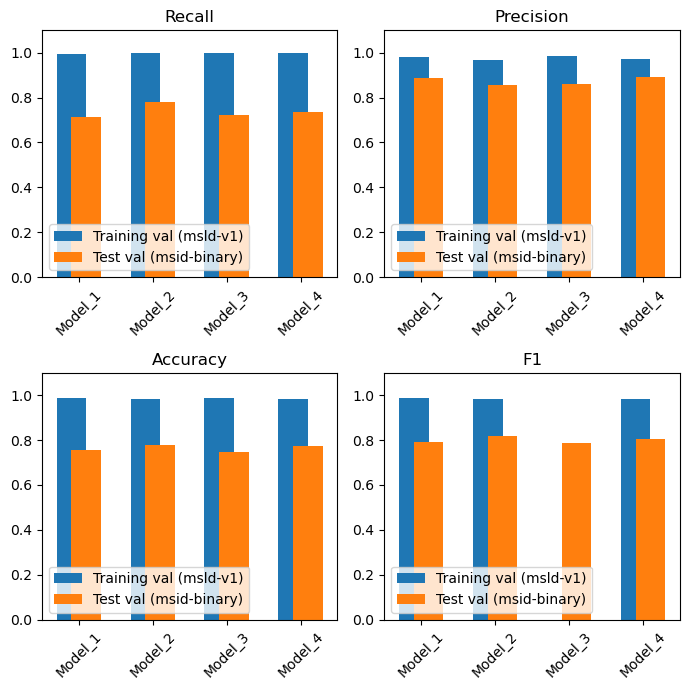

In [5]:
plot_training_and_validation_metrics(training_res_df, validation_res_df)

# Others

In [21]:
from PIL import Image

In [43]:
p2img_dir = data / 'MSLD-v1/Original/Monkeypox'

# img = Image.open(p2img_dir / 'M01_01.jpg')
# img = Image.open(p2img_dir / 'M08_01.jpg')
img = Image.open(p2img_dir / 'M26_01.jpg')
# img = Image.open(p2img_dir / 'M49_02.jpg')
print(img.size)
img_384 = img.resize((384, 384), Image.LANCZOS)
img_384.save(data / f"{Path(img.filename).stem}_384.jpg")
img_1024 = img.resize((1024, 1024), Image.LANCZOS)
img_1024.save(data / f"{Path(img.filename).stem}_1024.jpg")

(224, 224)
